c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--csebuetnlp--banglishbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.445600,0.505456,0.803000,0.793589
2,0.399100,0.446855,0.820000,0.811253
3,0.377400,0.551973,0.818000,0.802504
4,0.153200,0.825767,0.811000,0.791749
5,0.227700,0.892326,0.817000,0.799694
6,0.024000,1.065991,0.817000,0.796485
7,0.038300,1.099594,0.812000,0.805150
8,0.044000,1.137009,0.814000,0.806504
9,0.001600,1.211541,0.816000,0.796840
10,0.002000,1.175043,0.817000,0.804810


Evaluation results: {'eval_loss': 1.1750432252883911, 'eval_accuracy': 0.817, 'eval_f1': 0.8048102175128741, 'eval_runtime': 4.2822, 'eval_samples_per_second': 233.523, 'eval_steps_per_second': 14.712, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       753
         1.0       0.24      0.15      0.19        33
         2.0       0.70      0.52      0.60       214

    accuracy                           0.82      1000
   macro avg       0.60      0.53      0.56      1000
weighted avg       0.80      0.82      0.80      1000



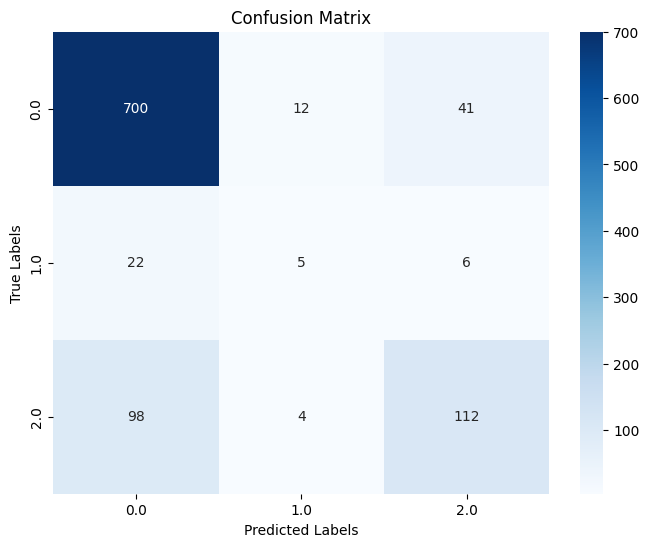

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# Load your dataset
data = pd.read_csv('RomanicBanglaSentiment.csv')

# Split data into features (X) and labels (y)
X = data['text']
y = data['sentiment']

# Encode labels into numeric values
label_encoder = LabelEncoder()
y = y.astype(str)  # Ensure labels are strings before encoding
y_encoded = label_encoder.fit_transform(y)

# Create Hugging Face Dataset
data_hf = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data_hf = data_hf.train_test_split(test_size=0.2, seed=42)

# Load pretrained tokenizer and model
model_name = 'csebuetnlp/banglishbert'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenize dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data_hf = data_hf.map(tokenize_function, batched=True)
data_hf = data_hf.remove_columns(['text'])
data_hf = data_hf.rename_column('label', 'labels')
data_hf.set_format('torch')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_hf['train'],
    eval_dataset=data_hf['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train the model
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Predict
predictions_output = trainer.predict(data_hf['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Get only used labels/classes
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [label_encoder.classes_[i] for i in used_labels]

# Classification report
report = classification_report(
    labels,
    predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/3999 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 41791.75 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_5564\57948479.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.609800,0.676874,0.753000,0.646901
2,0.700300,0.676551,0.753000,0.646901
3,0.679500,0.673340,0.753000,0.646901
4,0.671400,0.656690,0.753000,0.646901
5,0.686500,0.656856,0.753000,0.646901
6,0.737800,0.656561,0.753000,0.646901
7,0.705100,0.661349,0.753000,0.646901
8,0.631600,0.660554,0.753000,0.646901
9,0.668600,0.659373,0.753000,0.646901
10,0.699200,0.657909,0.753000,0.646901


Evaluation results: {'eval_loss': 0.6579089760780334, 'eval_accuracy': 0.753, 'eval_f1': 0.6469013120365089, 'eval_runtime': 2.5072, 'eval_samples_per_second': 398.853, 'eval_steps_per_second': 25.128, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      1.00      0.86       753
         1.0       0.00      0.00      0.00        33
         2.0       0.00      0.00      0.00       214

    accuracy                           0.75      1000
   macro avg       0.25      0.33      0.29      1000
weighted avg       0.57      0.75      0.65      1000



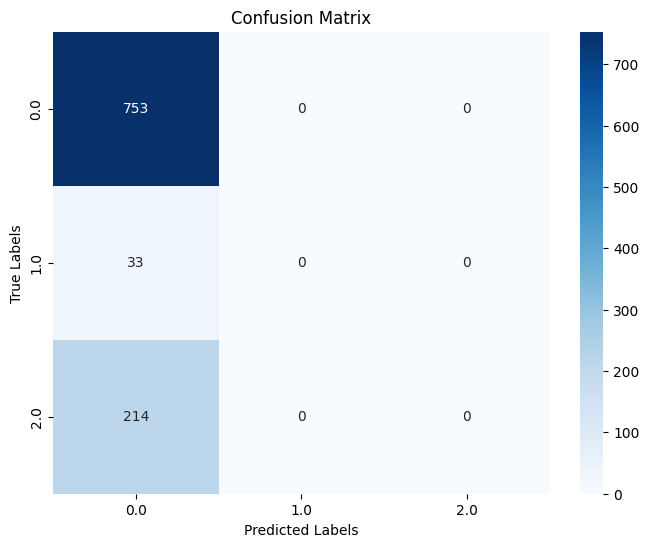

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# Load your dataset
data = pd.read_csv('RomanicBanglaSentiment.csv')

# Split data into features (X) and labels (y)
X = data['text']
y = data['sentiment']

# Encode labels into numeric values
label_encoder = LabelEncoder()
y = y.astype(str)  # Ensure labels are strings before encoding
y_encoded = label_encoder.fit_transform(y)

# Create Hugging Face Dataset
data_hf = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data_hf = data_hf.train_test_split(test_size=0.2, seed=42)

# Load pretrained tokenizer and model
model_name = 'csebuetnlp/banglishbert'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenize dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data_hf = data_hf.map(tokenize_function, batched=True)
data_hf = data_hf.remove_columns(['text'])
data_hf = data_hf.rename_column('label', 'labels')
data_hf.set_format('torch')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=3e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_hf['train'],
    eval_dataset=data_hf['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train the model
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Predict
predictions_output = trainer.predict(data_hf['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Get only used labels/classes
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [label_encoder.classes_[i] for i in used_labels]

# Classification report
report = classification_report(
    labels,
    predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
